In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset
import nibabel as nib

In [55]:
data_dir = '../data/processed/patches/val/class1'
for filename in os.listdir(data_dir):
    id = filename.split('-')[-1].split('.')[0]
    id = '0' * (4 - len(id)) + id 
    new_filename = 'patch-slice-' + id + '.jpeg'
    os.rename(data_dir + '/' + filename, data_dir + '/' + new_filename)

### Masks loading

In [56]:
masks = torch.load('/workspace/healthy_masks.pt')
masks.shape

(1440, 40, 40)

In [57]:
masks_resized = []
for mask in masks:
    masks_resized.append(cv2.resize(mask, (256, 256)) > 0.5)
masks_resized = np.stack(masks_resized)
masks_resized.shape

(1440, 256, 256)

In [58]:
np.savez('../data/processed/patches_/val/imagenet_freeform1020_masks.npz', mask=masks_resized.astype(np.uint8))

In [27]:
!cp ../data/imagenet_freeform1020_masks.npz ../data/processed/patches/val/imagenet_freeform1020_masks.npz

### Patches incorporation

In [86]:
recons = torch.load('../results/MriPatches/samples_nfe999/recon_0_24.pt')['arr']
recons.shape

torch.Size([40, 3, 256, 256])

In [87]:
recons = recons.mean(dim=1)
recons = [cv2.resize(np.array(slice), (40, 40)) for slice in recons]
recons = np.stack(recons, axis=2)
recons.shape

(40, 40, 40)

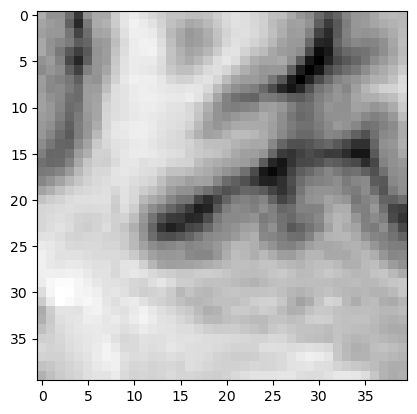

In [94]:
plt.imshow(recons[:, :, 5], cmap='gray')

In [96]:
gen_patches_3d = [np.stack(recons[i:i+40]) for i in range(0, len(recons), 40)]
len(gen_patches_3d)

1

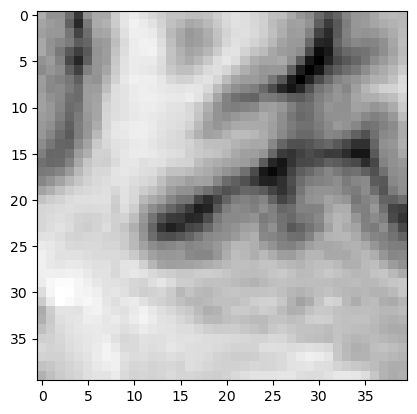

In [100]:
plt.imshow(gen_patches_3d[0][:, :, 5], cmap='gray')

In [104]:
patches_masks = np.array(torch.load('/workspace/healthy_patches_masks_norm.pt'))
brains = np.load('/workspace/healhy_brains_norm.npy')

In [123]:
brains[0].max()

650.419189453125

In [126]:
gen_brains = []

for (brain, patch_mask, gen_patch) in zip(brains[:1], patches_masks[:1], gen_patches_3d):
    gen_brain = brain.copy()
    gen_patch = ((gen_patch + 1) / 2) * brain[patch_mask].max()
    intensity_diff = 1 # np.mean(brain[patch_mask]) / np.mean(gen_patch)
    gen_brain[patch_mask] = (gen_patch * intensity_diff).flatten()
    gen_brains.append(gen_brain)

In [106]:
gen_brains[0].shape
np.where(patches_masks[0])

(array([37, 37, 37, ..., 76, 76, 76]),
 array([ 97,  97,  97, ..., 136, 136, 136]),
 array([ 69,  70,  71, ..., 106, 107, 108]))

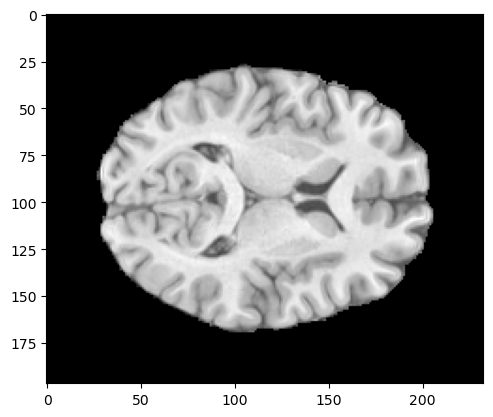

In [111]:
plt.imshow(brains[0][:, :, 79], cmap='gray')

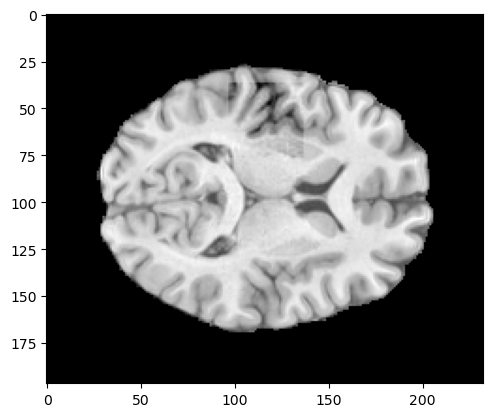

In [127]:
plt.imshow(gen_brains[0][:, :, 79], cmap='gray')

### Visualization

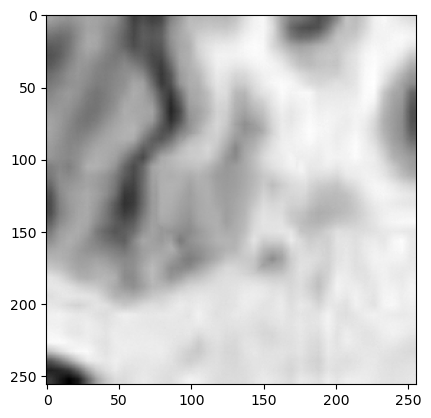

In [72]:
plt.imshow(recons.mean(dim=1)[20], cmap='gray')
plt.imshow(masks_resized[20], alpha=0.)

## Utils

In [3]:
import sys
sys.path.append('/workspace/I2SB')

from utils.data_utils import incorporate_gen_patches, HealthyBrainsDataset

In [42]:
def construct_gen_patches_i2sb(path: str):
    '''
    Input: str path to file with I2SB generations
    Output: np.array of patches (n_brains, 40, 40, 40), (0, 1)-normalized
    '''
    
    patches = torch.load(path)
    assert len(patches.shape) == 4   # (slice_num, 3, 256, 256)
    patches = patches.mean(dim=1)
    patches = np.stack([cv2.resize(np.array(slice), (40, 40)) for slice in patches])
    patches = np.stack([np.stack(patches[i:i+40], axis=2) for i in range(0, len(patches), 40)])

    patches = (patches + 1) / 2 # (-1, 1) --> (0, 1)

    return patches

In [31]:
norm_patches = construct_gen_patches_i2sb('../results/MriPatchesNorm/samples_nfe999/recon.pt')

In [32]:
healthy_brains_dataset = HealthyBrainsDataset(brains_path='/workspace/healhy_brains_norm.npy', 
                                              masks_path='/workspace/healthy_trainlike_masks_norm.pt',
                                              patch_masks_path='/workspace/healthy_patches_masks_norm.pt')

In [24]:
gen_brains_norm = incorporate_gen_patches(healthy_brains_dataset, norm_patches)

In [16]:
plt.imsave('i2sb-generation-example.jpeg', gen_brains_norm[0][:, :, 93], cmap='gray')

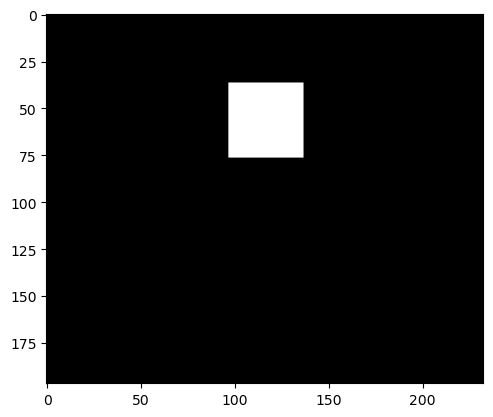

In [36]:
plt.imshow(healthy_brains_dataset[0][2][:, :, 90], cmap='gray')

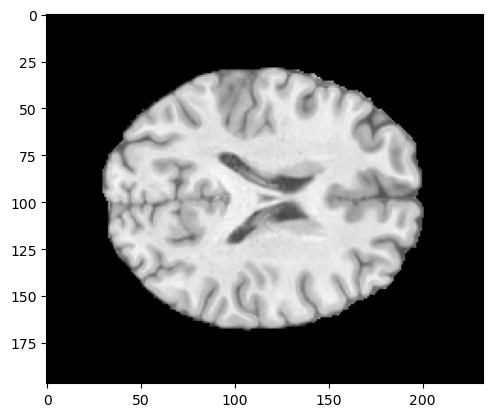

In [37]:
plt.imshow(healthy_brains_dataset[0][0][:, :, 90], cmap='gray')

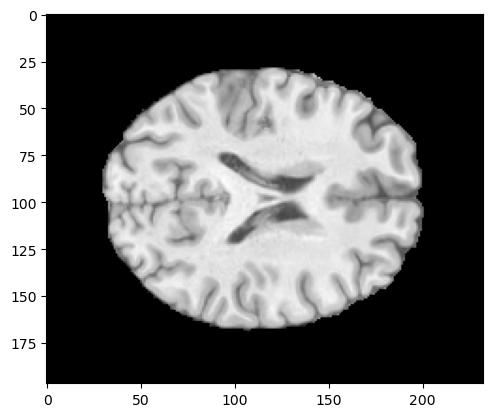

In [38]:
plt.imshow(gen_brains_norm[0][:, :, 90], cmap='gray')

In [39]:
np.save('../results/processed/gen_trainlike_norm.npy', gen_brains_norm)

## Order fix

In [27]:
gen_patches = torch.load('../results/MriPatches/samples_nfe999/recon.pt')['arr']

In [28]:
order_list = [str(num) for num in range(1440)]
order_list = [int(num) for num in sorted(order_list)]
true_inds = np.argsort(order_list)

In [29]:
gen_patches = gen_patches[true_inds]

In [30]:
torch.save(gen_patches, '../results/MriPatches/samples_nfe999/recon_right_order.pt')

In [40]:
healthy_brains_dataset = HealthyBrainsDataset(brains_path='/workspace/healthy_brains.npy', 
                                              masks_path='/workspace/healthy_trainlike_masks.pt',
                                              patch_masks_path='/workspace/healthy_patches_masks.pt')

In [43]:
gen_patches = construct_gen_patches_i2sb('../results/MriPatches/samples_nfe999/recon_right_order.pt')

In [44]:
gen_brains = incorporate_gen_patches(healthy_brains_dataset, gen_patches)

In [45]:
np.where(healthy_brains_dataset[0][0] != gen_brains[0])

(array([112, 112, 112, ..., 133, 133, 133]),
 array([77, 77, 77, ..., 91, 92, 92]),
 array([135, 136, 137, ..., 139, 136, 137]))

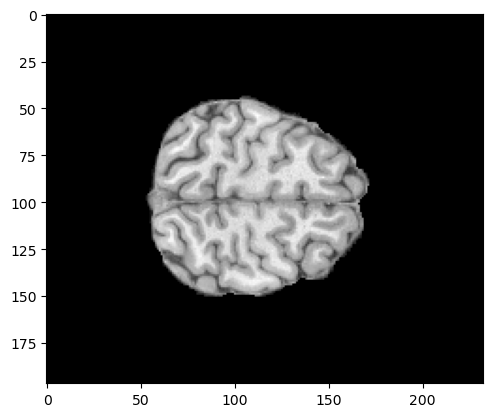

In [46]:
plt.imshow(healthy_brains_dataset[0][0][:, :, 136], cmap='gray')

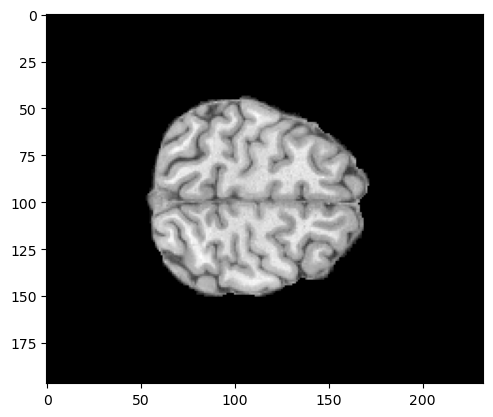

In [47]:
plt.imshow(gen_brains[0][:, :, 136], cmap='gray')

In [48]:
np.save('../results/processed/gen_trainlike.npy', gen_brains)

In [ ]:
brain_fcd_masks = []

for idx, patch_mask in enumerate(patches_masks):
    brain_fcd_mask = patch_mask.copy()
    brain_fcd_mask[np.where(brain_fcd_mask)] = np.where(masks.transpose(1, 2, 0)[:, :, 40*idx:40*(idx+1)].flatten(), True, False)
    brain_fcd_masks.append(brain_fcd_mask)

## Masks restoring (shame)

In [49]:
masks = np.load('../data/processed/patches/val/trainlike_masks/imagenet_freeform1020_masks.npz')['mask']
norm_masks = np.load('../data/processed/patches_norm/val/trainlike_masks/imagenet_freeform1020_masks.npz')['mask']

In [50]:
masks = [cv2.resize(mask, (40, 40)) for mask in masks]
norm_masks = [cv2.resize(mask, (40, 40)) for mask in norm_masks]

In [51]:
masks = np.stack(masks)
norm_masks = np.stack(norm_masks)

In [52]:
masks = masks.reshape(-1, 40, 40, 40)
norm_masks = norm_masks.reshape(-1, 40, 40, 40)

In [53]:
patch_masks = torch.load('/workspace/healthy_patches_masks.pt')
patch_norm_masks = torch.load('/workspace/healthy_patches_masks_norm.pt')

In [54]:
for i in range(len(masks)):
    patch_masks[i][patch_masks[i] == True] = masks[i].astype(bool).flatten()

for i in range(len(patch_norm_masks)):
    patch_norm_masks[i][patch_norm_masks[i] == True] = norm_masks[i].astype(bool).flatten()

In [55]:
torch.save(patch_masks, '/workspace/healthy_trainlike_masks_full.pt')
torch.save(patch_norm_masks, '/workspace/healthy_trainlike_masks_norm_full.pt')